In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
from tqdm import tqdm
from scipy.optimize import curve_fit

import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from astropy.io import fits
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
from astropy.table import Table, vstack, hstack, join
from astropy.modeling import models
from specutils.fitting import find_lines_threshold, find_lines_derivative, fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import NDUncertainty

from astroquery.simbad import Simbad
from astroquery.nist import Nist
from astroquery.xmatch import XMatch
from astroquery.vizier import Vizier
from astroquery.mast import Observations

%matplotlib inline

In [84]:
aangstrom2meter = 10**-10
joules2ergs = 10**7

In [85]:
## Where should results be saved to?

analysispath = '/Users/isabelkain/Desktop/GALEX/analysis'
datapath = '/Users/isabelkain/Desktop/GALEX/data'

In [86]:
def redshift_correction(wavelengths_observed, z):
    '''
    Finds amount by which stellar emission is redshifted, and subtract this from stellar spectrum.
    Input:
    wavelengths_observed: observed wavelengths of spectrum (Angstroms)
    z: redshift of star
    
    Returns:
    wavelengths_emitted: emitted wavelengths of spectrum (Angstroms)
    '''
    
    wavelengths_emitted = wavelengths_observed / (1 + z)
    return wavelengths_emitted


def blackbody(wavelengths, Teff):
    '''
    Returns blackbody continuum for an object at Teff (K)
    Inputs:
    wavelengths [arr]: (Angstroms)
    Teff [scalar]: effective temperature (K)
    
    Returns:
    B [arr]: blackbody continuum for Teff (unitless)
    '''
    
    wav = wavelengths * aangstrom2meter * u.m
    Teff = Teff * u.K
    
    B = (2. * const.h * const.c**2) / (wav**5.) / ( np.exp( (const.h * const.c) / (wav * const.k_B * Teff) ) - 1. )
    
    return B / B.max()


def fitBB(wavelengths, Teff, a, b):
    '''
    Scale blackbody continuum emission.
    Input:
    wavelengths [arr]: spectrum wavelengths (Angstroms)
    Teff [scalar]: effective temperature of star (K)
    a, b: scaling factors to be optimized by curve_fit
    
    Returns:
    -- [arr]: blackbody continuum curve
    '''
    return a * blackbody(wavelengths, Teff) + b

# Read in data

In [87]:
table = Table.read('/Users/isabelkain/Desktop/GALEX/data/dataset.ecsv')

swpid = table['obs_id'][table['main_id']=='* gam Mic'][0]
starname = table['main_id'][table['main_id']=='* gam Mic'][0] #.replace(' ','')
objname = starname.replace(' ','')

print(starname, swpid, objname)

* gam Mic swp54894 *gamMic


In [88]:
## Open FITS file

hdul = fits.open(f'{datapath}/{swpid}.fits')


# Collect info, apply redshift and BB corrections

In [89]:
## Collect exposure information from header

# target = hdul[1].header['OBJECT']       # target name
spclass = hdul[1].header['SRCCLASS']    # Object Class 
camera = hdul[0].header['CAMERA']       # or hdul[1].header['INSTRUME']
dispersion = hdul[0].header['DISPERSN'] # LOW or HIGH
fluxcal = hdul[1].header['FLUX_CAL']    # should be ABSOLUTE
tstart = float(str(hdul[0].header['?JD-OBS']).split('=')[1].split('/')[0].strip())      # [d] MJD exposure start time 
exptime = hdul[1].header['EXPOSURE']    # [s] eff. exposure duration
snr = hdul[1].header['DER_SNR']         # Derived signal-to-noise ratio  


## Record redshift & temperature

z = table[table['main_id']==starname]['redshift'].value[0]
Teff = table[table['main_id']==starname]['Fe_H_Teff'].value[0]

if Teff == 0: Teff = 5000. # guess value of 5000 K if no Teff available


## Read in wavelength, flux, and fluxerr data

wavelengths = redshift_correction(hdul[1].data['WAVE'][0], z)
rawflux = hdul[1].data['FLUX'][0] # raw because blackbody continuum will soon be subtracted
fluxerr = hdul[1].data['SIGMA'][0]

print(objname)
print(spclass)
print(camera)
print(dispersion)
print(fluxcal)
print(tstart)
print(exptime)
print(snr)

*gamMic
G III-I
SWP
LOW
ABSOLUTE
2449875.41707
3599.844
3.78


Text(0.5, 1.0, 'LOW-DISP SWP, G III-I, SNR 3.78')

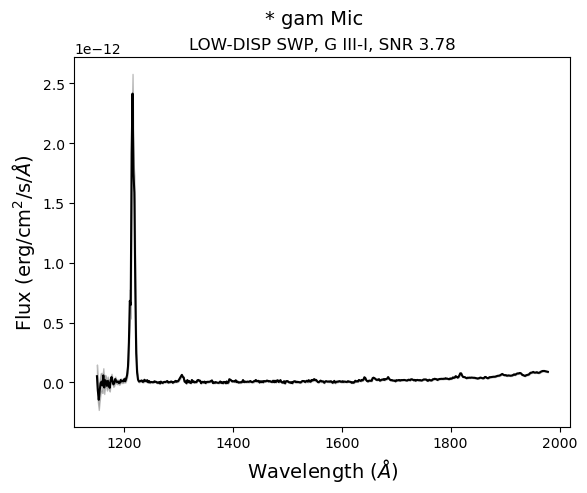

In [90]:
## Visualize spectrum

plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, rawflux, c='k')
plt.fill_between(wavelengths, rawflux + fluxerr, rawflux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

# plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}_raw.png', bbox_inches='tight')
# 
# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

## Subtract blackbody continuum

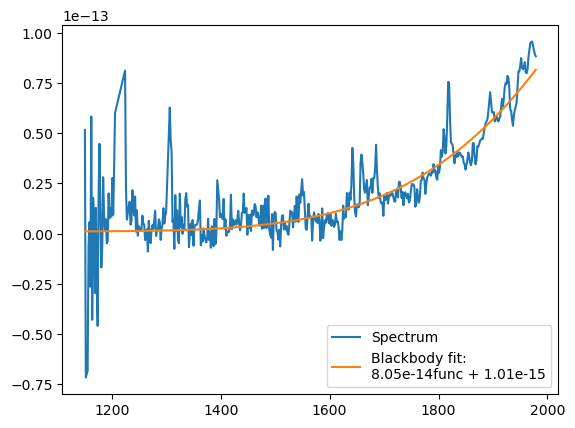

In [91]:
## Scale BB curve 

## Mask most features to let curve_fit see the underlying emission

med = np.median(rawflux)
std = np.std(rawflux)
mask = np.logical_and((rawflux <= med + .5*std), (rawflux >= med - .5*std))

x = wavelengths[mask]
y = rawflux[mask]
yerr = fluxerr[mask]

## Fit blackbody curve to masked stellar spectrum

popt, pcov = curve_fit(lambda x, a, b: fitBB(x, Teff, a, b), x, y, sigma=yerr) 


## Plot masked spectrum and scaled blackbody curve

plt.plot(x, y, label='Spectrum')
plt.plot(wavelengths, fitBB(wavelengths, Teff, popt[0], popt[1]), 
         label=f'Blackbody fit:\n{popt[0]:0.2e}func + {popt[1]:0.2e}')
plt.legend()

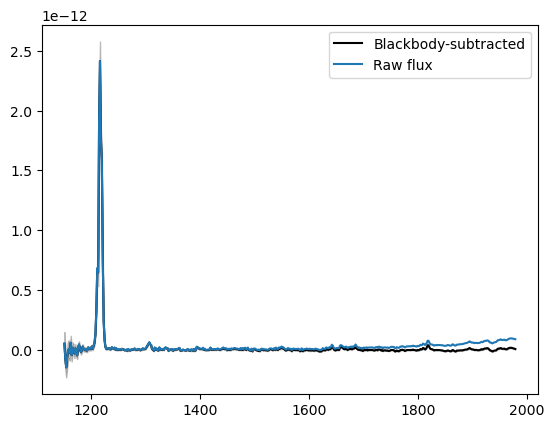

In [92]:
## Subtract BB curve

flux = rawflux - fitBB(wavelengths, Teff, popt[0], popt[1])

## Plot BB-subtracted flux

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.plot( wavelengths, rawflux, label='Raw flux' )
plt.legend()

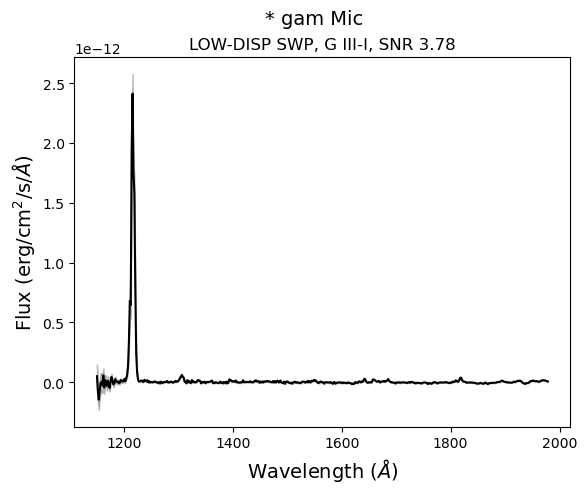

In [93]:
## Visualize BB-subtracted spectrum

# plt.tight_layout(rect=[0, 0.03, 1, 0.90])

plt.plot( wavelengths, flux, color='k', label='Blackbody-subtracted' )
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')

plt.xlabel(r'Wavelength ($\AA$)', fontsize=14)
plt.ylabel(r'Flux (erg/cm$^2$/s/$\AA$)', fontsize=14)

plt.suptitle(f'{starname}', fontsize=14)
plt.title(f'{dispersion}-DISP {camera}, {spclass}, SNR {snr}')

plt.savefig(f'{analysispath}/{swpid}_{objname}/{swpid}.png', bbox_inches='tight')

# plt.ylim(-.2*10**-13, .5*10**-13)
# plt.yscale('log')

# Search for lines in spectrum

In [94]:
## CReate a Spectrum1D object
spectrum = Spectrum1D(flux = flux * (u.erg/u.cm**2/u.s/u.AA), spectral_axis = wavelengths * u.AA)

## Define the uncertainty of the spectrum using everything redward of the H line FIXME
noise_region = SpectralRegion(np.floor(wavelengths[0])*u.AA, 
                              np.ceil(wavelengths[-1])*u.AA)

spectrum = noise_region_uncertainty(spectrum, noise_region)

# spectrum

line_center,line_type,line_center_index
Angstrom,,
float32,str10,int64
1175.6602783203125,emission,15
1184.041748046875,emission,20
1214.2149658203125,emission,38
1230.9779052734375,emission,48
1256.1221923828125,emission,63
1304.734619140625,emission,92
1316.4686279296875,emission,99
1324.85009765625,emission,104


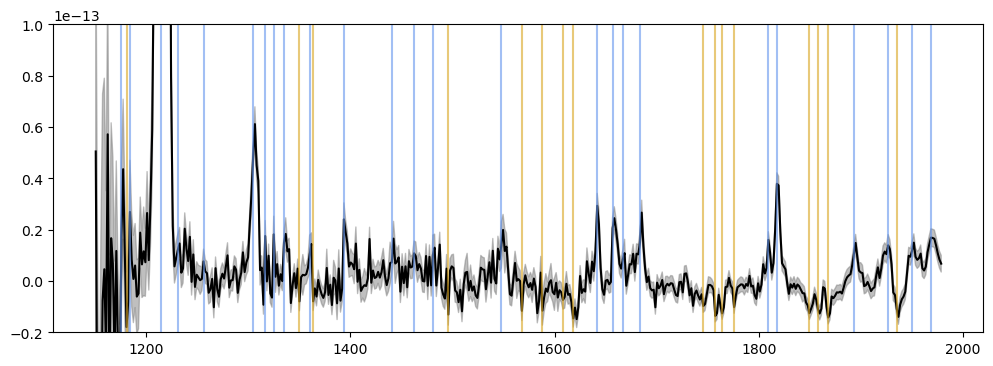

In [95]:
## Find lines using a noise threshold

with warnings.catch_warnings():  # Ignore warnings

    warnings.simplefilter('ignore')

#     lines = find_lines_threshold(spectrum, noise_factor=3) 
    lines = find_lines_derivative(spectrum, 10*np.median(flux)*(u.erg/u.cm**2/u.s/u.AA)) # flux_threshold=5*np.median(flux) * (u.erg/u.cm**2/u.s/u.AA)

display(lines)


## Plot identified lines

plt.figure(figsize=(12,4))
plt.plot( wavelengths, flux, c='k')
plt.fill_between(wavelengths, flux + fluxerr, flux - fluxerr, alpha=0.5, color='gray')
plt.ylim(-2*10**-14, 10**-13)


for l in lines:
    
    if l['line_type']=='emission':
        plt.vlines(l['line_center'].value, -2*10**-14, 10**-13, alpha=0.6, color='cornflowerblue')
    elif l['line_type']=='absorption':
        plt.vlines(l['line_center'].value, -2*10**-14, 10**-13, alpha=0.6, color='goldenrod')
    
#     print(l['line_center'].value)

In [96]:
lines[lines['line_type']=='emission']

line_center,line_type,line_center_index
Angstrom,,
float32,str10,int64
1175.6602783203125,emission,15
1184.041748046875,emission,20
1214.2149658203125,emission,38
1230.9779052734375,emission,48
1256.1221923828125,emission,63
1304.734619140625,emission,92
1316.4686279296875,emission,99
1324.85009765625,emission,104


In [99]:
cen = lines['line_center'][2]
cen.value

1214.215

# Search NIST for matching lines

In [148]:
search_wavelengths = np.ma.array(data=wavelengths)
search_wavelengths

masked_array(data=[1150.516 , 1152.1924, 1153.8687, 1155.5448, 1157.2211,
                   1158.8973, 1160.5737, 1162.25  , 1163.9263, 1165.6025,
                   1167.2788, 1168.9552, 1170.6315, 1172.3077, 1173.984 ,
                   1175.6603, 1177.3367, 1179.013 , 1180.6892, 1182.3655,
                   1184.0417, 1185.7181, 1187.3944, 1189.0707, 1190.747 ,
                   1192.4232, 1194.0995, 1195.7759, 1197.452 , 1199.1283,
                   1200.8046, 1202.481 , 1204.1572, 1205.8335, 1207.5098,
                   1209.186 , 1210.8624, 1212.5387, 1214.215 , 1215.8912,
                   1217.5675, 1219.2439, 1220.9202, 1222.5964, 1224.2727,
                   1225.949 , 1227.6254, 1229.3016, 1230.9779, 1232.6542,
                   1234.3304, 1236.0067, 1237.6831, 1239.3593, 1241.0355,
                   1242.7118, 1244.3882, 1246.0645, 1247.7407, 1249.417 ,
                   1251.0933, 1252.7697, 1254.4459, 1256.1222, 1257.7985,
                   1259.4747, 1261.151

Line center:  1230.9779


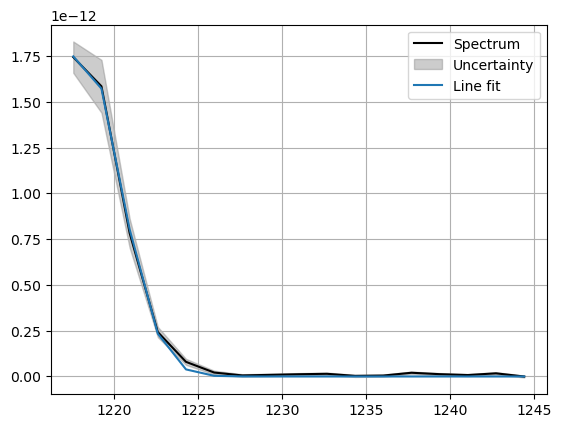

In [145]:
## Make copy of spectrum to mask lines as we fit them

search_wavelengths = np.ma.array(data=wavelengths)
search_flux = = np.ma.array(data=flux)


## Plot window around line center

cen = lines['line_center'][3].value
margin = 15 # AA
print('Line center: ', cen)

ulim = cen - margin
hlim = cen + margin

trim = (wavelengths >= ulim) & (wavelengths < hlim)
x = wavelengths[trim]
y = flux[trim]
yerr = fluxerr[trim]


## Fit Gaussian to line

spectrum = Spectrum1D(flux = y * (u.erg/u.cm**2/u.s/u.AA), 
                      spectral_axis = x * u.AA)

g_init = models.Gaussian1D(amplitude=y.max()* (u.erg/u.cm**2/u.s/u.AA), 
                           mean=np.median(x)*u.AA, 
                           stddev=0.01*np.median(x)*u.AA)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(x * u.AA)


## Check if fit succeeded or didn't find anything FIXME
fail = np.all(np.abs(y_fit.value)==0.)

if fail:
    print('Fit failed. No line found.')
    
else:
    ## Mask out found line

    
# Plot the original spectrum and the fitted.
plt.figure()
plt.plot( x, y, c='k', label='Spectrum' )
plt.fill_between( x, y-yerr, y+yerr, alpha=0.4, color='gray', label='Uncertainty' )
plt.plot( x, y_fit, label='Line fit' )
plt.grid(True)
plt.legend()

In [146]:
g_fit

<Gaussian1D(amplitude=0. erg / (Angstrom cm2 s), mean=1218.09088052 Angstrom, stddev=2.23018129 Angstrom)>

In [131]:
print( np.abs( g_fit.amplitude.value ) )
print( np.abs(y).min() )
print(np.median(y))
print(np.std(y))

1.7110788528813488e-15
7.83680176755599e-16
6.869139470151416e-15
2.769099612966435e-14


In [130]:
g_fit.amplitude

Parameter('amplitude', value=-1.7110788528813488e-15, unit=erg / (Angstrom cm2 s))

Peak at 1216.33 Angstroms
No result for Cl


,Spectrum,Observed,Rel.,Acc.
0,H I,1215.6701,8.040000e+11,AAA
1,Na II,1213.9980,3.000000e+03,NaN
2,Na II,1217.4720,4.050000e+03,NaN
3,Mg IV,1218.9920,8.000000e+01,B
4,Si II,1216.1200,1.000000e+03,NaN
5,S I,1213.9900,0.000000e+00,NaN
6,S I,1214.2950,1.000000e+01,NaN
7,S I,1214.3180,2.000000e+03,NaN
8,S I,1214.6410,3.000000e+01,NaN
9,S I,1214.9800,0.000000e+00,NaN


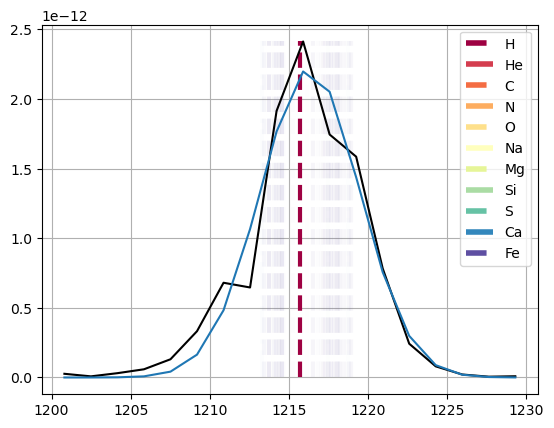

In [101]:
# if not fail:

## Set window around peak based on best-fit mean and stddev values

ulim = g_fit.mean.value - 1*g_fit.stddev.value
hlim = g_fit.mean.value + 1*g_fit.stddev.value

print(f'Peak at {g_fit.mean.value:0.2f} Angstroms')


#################################
## Query NIST for nearby lines ##
#################################

NISTresults = pd.DataFrame(columns=['Spectrum', 'Observed', 'Rel.', 'Acc.'])
elements = ['H', 'He', 'C', 'N', 'O', 'Na', 'Mg', 'Si', 'S', 'Cl', 'Ca', 'Fe']
found_el = []

for i, el in enumerate(elements):

    try:
        result = Nist.query(ulim * u.AA, hlim * u.AA, linename=f"{el}")

    except:
        print(f'No result for {el}')
        continue
        
    ## Count number of elements with matching lines
    found_el.append(i)

    ## Save line information

    try:    spec = result['Spectrum'].data
    except: spec = np.array([f'{el} I']*len(result))

    newresult = pd.DataFrame( data={'Spectrum':spec, 
                                    'Observed':result['Observed'].data, 
                                    'Rel.':result['Rel.'].data.astype(str), 
                                    'Acc.':result['Acc.'].data} )

    newresult.dropna(axis=0, subset=['Observed', 'Rel.'], inplace=True)
    NISTresults = pd.concat([NISTresults, newresult], axis=0, ignore_index=True)


## Reformat relative intensities column (strip keyword info)
NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('[,()\*a-zA-Z]', '', regex=True).str.strip()
NISTresults['Rel.'] = NISTresults['Rel.'].str.replace('', '0', regex=True).str.strip()
NISTresults['Rel.'] = NISTresults['Rel.'].astype(float)
display(NISTresults)

#######################
## Visualize results ##
#######################

## From list of indices, which elements had matching lines?
identified_elements = [elements[i] for i in found_el]

## Set colormap, opacities for plotting
cmap = mpl.colormaps['Spectral'] # gist_rainbow is clearer but uglier
colors = cmap(np.linspace(0,1,len(identified_elements)))
maxint = NISTresults['Rel.'].max()

for i, el in enumerate(identified_elements):
    
    ## Isolate lines attributed to l, plot each one
    el_lines = NISTresults.loc[NISTresults['Spectrum'].str.contains(f'{el} ')]
    
    if i%2==0: ls = '--'
    else: ls = '-.'
    
    for j, l in el_lines.iterrows():
        plt.vlines(l['Observed'], y.min(), y.max(), 
                   alpha=(float(l['Rel.'])/maxint)**.3, ls=ls, lw=3, color=colors[i])
    
## Save legend handles
handles = []

for i in range(0, len(identified_elements)):
    
    if i%2==0: ls = '--'
    else: ls = '-.'
    
    handles = np.append( handles, Line2D([0], [0], color=colors[i], 
                                         lw=4, ls=ls, label=f'{identified_elements[i]}') )

    
## Plot

plt.plot( x, y, c='k' )
plt.plot( x, y_fit )
plt.legend(handles, identified_elements)
plt.grid(True)
plt.show()
